In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import classification_report#这个包是评价报告
from sklearn.model_selection import train_test_split
import copy

In [2]:
df = pd.read_csv("spiral_data/3class.txt",delimiter=" ",names=["x1","x2","y"])
x1 = df["x1"]
x2 = df["x2"]
X_train = np.array(df[["x1","x2"]])
y_train = np.array(df["y"])
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=4)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2402, 2), (601, 2), (2402,), (601,))

<Figure size 720x576 with 0 Axes>

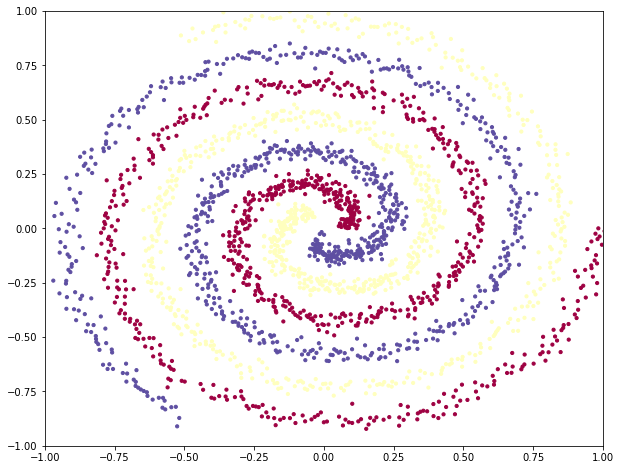

In [3]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(wspace =0, hspace =0.3)

fig = plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

In [4]:
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):    
    return np.maximum(0, x)

# 防止溢出
def softmax(a):    
    c = np.max(a)    
    exp_a = np.exp(a - c) # 溢出对策    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a
    return y

def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [5]:
input_size = 2
hidden_size = 100
output_size = 3
std = 1e-2
alpha = 0.5
# rand函数根据给定维度生成[0,1)之间的数据，shape(input_size, hidden_size)
W1 = std * np.random.randn(input_size, hidden_size)   #(2,10)
b1 = np.zeros((1, hidden_size))                       #(1,10)
W2 = std * np.random.randn(hidden_size,output_size)   #(10,1)
b2 = np.zeros((1, output_size))                       #(1,1)

params = {}
params["W1"] = W1
params["b1"] = b1
params["W2"] = W2
params["b2"] = b2

def accuracy(y,t):
    predicted_class = np.argmax(y, axis=1)
    return (np.mean(predicted_class == t))

def predict(X,y,params):
    hidden_layer = np.maximum(0, np.dot(X, params["W1"]) + params["b1"])
    scores = np.dot(hidden_layer, params["W2"]) + params["b2"]
#     predicted_class = np.argmax(y, axis=1)
    return scores


def computeLoss(y,t): # y->predict value t->true value
    num_examples = y.shape[0]
    correct_logprobs = -np.log(y[range(num_examples),t] + 1e-5)
    data_loss = np.mean(correct_logprobs)
    loss = data_loss 
    return loss

In [6]:
def forward_propagation(params,X):
    z1 = np.dot(X,params["W1"]) + params["b1"]              
    a1 = relu(z1)                 
    z2 = np.dot(a1,params["W2"]) + params["b2"]     
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
    a2 = probs
    return z1,a1,z2,a2
z1,a1,z2,a2= forward_propagation(params,X_train)

In [34]:
def savePic(params,X,y,figname):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], stats["params"]["W1"]) + stats["params"]["b1"]), stats["params"]["W2"]) + stats["params"]["b2"]
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.savefig(figname+".jpeg")

In [38]:
def train(X,y,X_t,y_t,params,iterations):
    best_acc = -1
    best_params = {}
    loss_history = []
    acc_history = []
    acc_t_history = []
    loss_t_history = []
    num_examples = X.shape[0]
    for i in range(iterations):
        z1,a1,z2,a2 = forward_propagation(params,X)
        tz1,ta1,tz2,ta2 = forward_propagation(params,X_t)
        loss = computeLoss(a2,y)
        loss_t = computeLoss(ta2,y_t)
        
        acc = accuracy(a2,y)
        acc_t = accuracy(ta2,y_t)
        
        if i % 1000 == 0:
            loss_history.append(loss)
            acc_history.append(acc)

            loss_t_history.append(loss_t)
            acc_t_history.append(acc_t)
            
            savePic(params,X,y,str(i))
            savePic(params,X_t,y_t,str(i)+"t")
            
            print("iteration %d: loss %f acc %f" % (i, loss,acc))
                
        
        if acc > best_acc:
            best_acc = acc 
            best_params = copy.deepcopy(params)  # 深复制 指向的不是同一内存空间，对name_info做任何修改，info3的值都不会变化

        dscores = a2
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
        dW2 = np.dot(a1.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        dhidden = np.dot(dscores,params["W2"].T)
        dhidden[z1 <= 0] = 0
        dW = np.dot(X.T,dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)

        # perform a parameter update
        params["W1"] += -alpha * dW
        params["b1"] += -alpha * db
        params["W2"] += -alpha * dW2
        params["b2"] += -alpha * db2
        
    return {   
        'loss_history': loss_history,   
        'acc_history': acc_history,   
        'loss_t_history': loss_t_history,   
        'acc_t_history': acc_t_history, 
        "params": best_params,
        "best_acc":best_acc,
    } 

iteration 0: loss 0.998902 acc 0.388010
iteration 1000: loss 0.990739 acc 0.411740


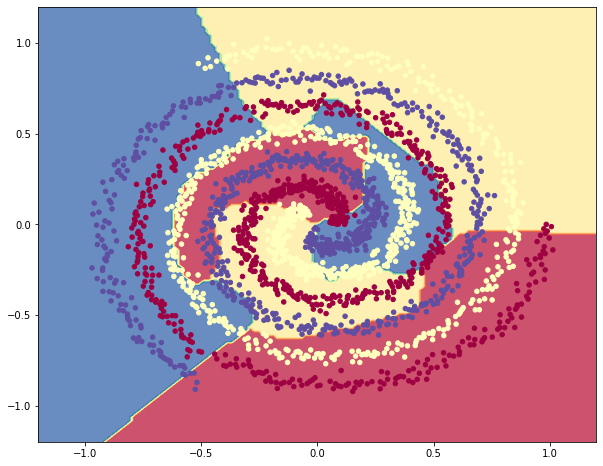

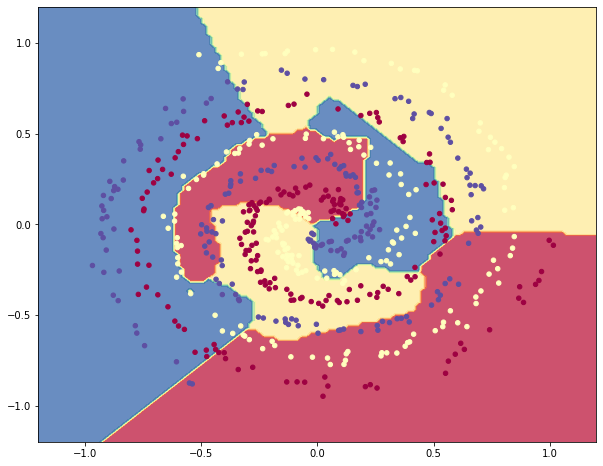

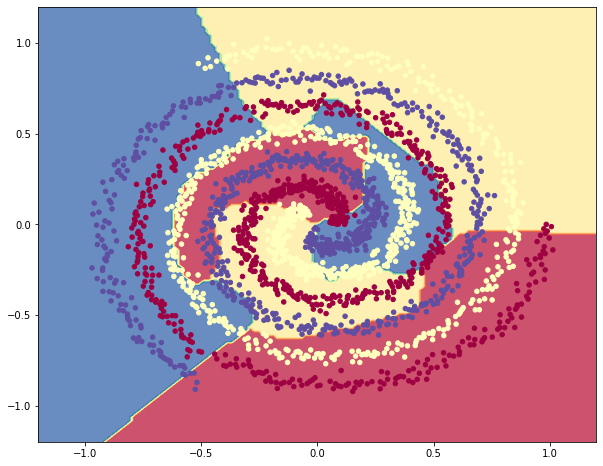

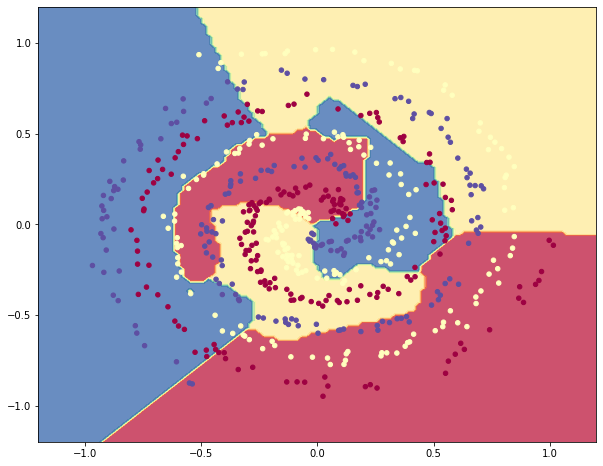

In [39]:
stats = train(X_train,y_train,X_test,y_test,params,2000)

In [25]:
stats["best_acc"]

0.4504579517069109

In [26]:
accuracy(predict(X_train,y_train,stats["params"]),y_train)

0.4504579517069109

In [27]:
accuracy(predict(X_test,y_test,stats["params"]),y_test)

0.4425956738768719

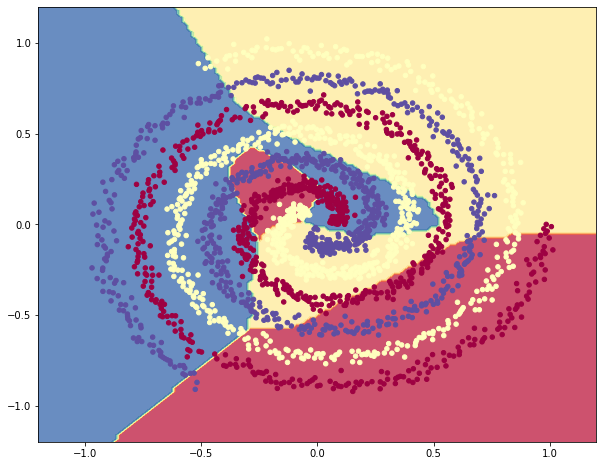

In [28]:
h = 0.02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], stats["params"]["W1"]) + stats["params"]["b1"]), stats["params"]["W2"]) + stats["params"]["b2"]
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, cmap=plt.cm.Spectral)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.savefig("1.jpeg")
plt.show()

In [29]:
Z.shape

(198, 200)

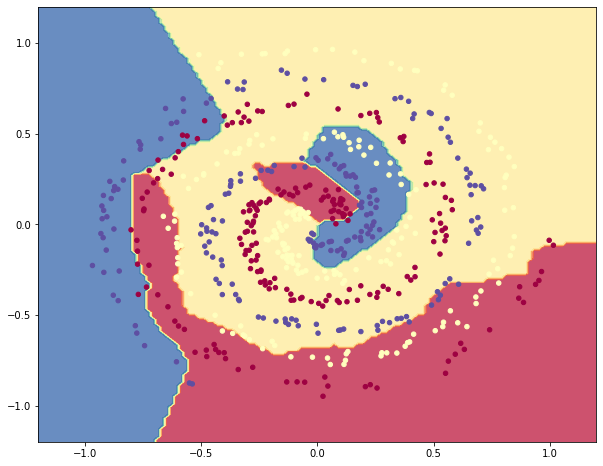

In [41]:
h = 0.02
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], stats["params"]["W1"]) + stats["params"]["b1"]), stats["params"]["W2"]) + stats["params"]["b2"]
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, cmap=plt.cm.Spectral)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.show()

In [46]:
Z.shape

(196, 200)

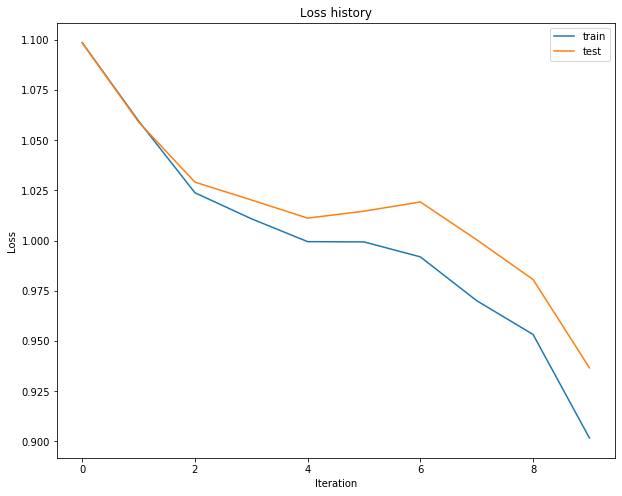

In [149]:
plt.plot(stats['loss_history'], label='train')
plt.plot(stats['loss_t_history'], label='test')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


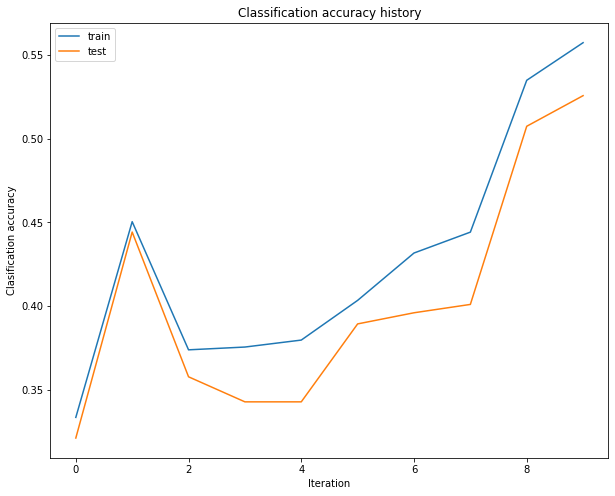

In [150]:
plt.plot(stats['acc_history'], label='train')
plt.plot(stats['acc_t_history'], label='test')
plt.title('Classification accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Clasification accuracy')
plt.legend()